<a href="https://colab.research.google.com/github/deburky/calibration/blob/main/Measuring_calibration_accuracy_PD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Technical appendix to *Measuring calibration accuracy of modern PD models*



<div class="alert alert-info">
<b>Description:</b> This notebook contains a technical appendix on the ECE metric used in the context of calibration of probability of default (PD) credit risk models.
</div>

In [170]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

from IPython.display import Markdown
from scipy import optimize, stats
from scipy.optimize import minimize

from sklearn import metrics
from sklearn import model_selection
from sklearn.metrics import roc_auc_score
from statsmodels import distributions

from sklearn.metrics import brier_score_loss
from sklearn.calibration import calibration_curve
from matplotlib.gridspec import GridSpec

pd.set_option('display.max_columns', None)

### Functions
---

In [172]:
# Source: https://arxiv.org/abs/1710.08901

def generate_data(corr=0.85, size=1000):
    np.random.seed(5)
    xx = np.array([0, 1])
    yy = np.array([0, 1])
    means = [xx.mean(), yy.mean()]
    stds = [xx.std() / 3, yy.std() / 3]
    covs = [[stds[0]**2 , stds[0]*stds[1]*corr],
    [stds[0]*stds[1]*corr, stds[1]**2]]
    m = np.random.multivariate_normal(means, covs, size).T
    predicted = pd.Series(m[0])
    predicted.loc[predicted < 0] = 0.001 # to avoid inf
    predicted.loc[predicted > 1] = 0.999 # to avoid inf
    observed = m[1].round()
    data = pd.DataFrame({'Predicted': predicted,
    'Observed': observed})
    return data

In [173]:
# ECE
# Source: https://colab.research.google.com/drive/1H_XlTbNvjxlAXMW5NuBDWhxF3F2Osg1F?usp=sharing

def calc_bins(obs, preds):
  # Assign each prediction to a bin
  num_bins = 10
  bins = np.linspace(0.1, 1, num_bins)
  binned = np.digitize(preds, bins)

  # Save the accuracy, confidence and size of each bin
  bin_accs = np.zeros(num_bins)
  bin_confs = np.zeros(num_bins)
  bin_sizes = np.zeros(num_bins)

  for bin in range(num_bins):
    bin_sizes[bin] = len(preds[binned == bin])
    if bin_sizes[bin] > 0:
      bin_accs[bin] = (obs[binned==bin]).sum() / bin_sizes[bin]
      bin_confs[bin] = (preds[binned==bin]).sum() / bin_sizes[bin]

  return bins, binned, bin_accs, bin_confs, bin_sizes

def get_metrics(obs, preds):
  ECE = 0
  MCE = 0
  bins, _, bin_accs, bin_confs, bin_sizes = calc_bins(obs, preds)

  for i in range(len(bins)):
    abs_conf_dif = abs(bin_accs[i] - bin_confs[i])
    ECE += (bin_sizes[i] / sum(bin_sizes)) * abs_conf_dif
    MCE = max(MCE, abs_conf_dif)

  return ECE, MCE

### Data
---

In [174]:
# Generate data
pf = generate_data(corr=0.55, size=10000)
pf['Logit'] = np.log(pf.Predicted/(1-pf.Predicted)) # creating a logit vector

# Train test split
X_train, X_test, y_train, y_test = model_selection.train_test_split(pf[['Predicted', 'Logit']], pf['Observed'], test_size=0.2, random_state=42)

# generate validation set
pf_val = pd.merge(X_test.reset_index(drop=True), y_test.reset_index(drop=True), left_index=True, right_index=True)

### Calibration process
---

#### Logit calibration

In [175]:
# calibration parameters estimation
clb_curve = sm.Logit(y_train, sm.add_constant(X_train.Logit.to_numpy())).fit()
print(f'alpha={clb_curve.params[0]}, beta={clb_curve.params[1]}')
pf_val['logit_pd'] = clb_curve.predict(sm.add_constant(pf_val['Logit'].to_numpy()))

Optimization terminated successfully.
         Current function value: 0.585905
         Iterations 6
alpha=-0.02600538517515812, beta=1.4601059315342217


#### Non-linear least squares calibration

In [176]:
# calibration parameters estimation
def func(x, a, b):
    y = 1 / (1 + np.exp(-(a + b * x)))
    return y

alpha, beta = optimize.curve_fit(func, xdata = X_train['Logit'], ydata = y_train)[0]
print(f'alpha={alpha}, beta={beta}')

pf_val['nonlin_ls_pd'] = 1/(1+np.exp(-(alpha+beta*pf_val['Logit'])))

alpha=-0.020698780372665256, beta=1.4825729025719927


#### Robust logit calibration

In [177]:
# Methodology source: Tasche 2013, https://arxiv.org/pdf/1212.3716.pdf
# Implementation source: https://github.com/Densur/LDPD

# train set processing
portfolio = X_train['Logit']
portfolio_size = len(portfolio)
portfolio_ecdf = distributions.ECDF(portfolio)
portfolio_dist = np.minimum(portfolio_ecdf(portfolio), 1 - 1.0 / portfolio_size)

# test set processing
portfolio_test = X_test['Logit']
portfolio_size_test = len(portfolio_test)
portfolio_ecdf_test = distributions.ECDF(portfolio_test)
portfolio_dist_test = np.minimum(portfolio_ecdf(portfolio_test), 1 - 1.0 / portfolio_size_test)

# calibration parameters estimation
clb_curve_robust = sm.Logit(y_train, sm.add_constant(stats.norm.ppf(portfolio_dist))).fit()
print(f'alpha={clb_curve_robust.params[0]}, beta={clb_curve_robust.params[1]}')
pf_val['rob_logit_pd'] = clb_curve_robust.predict(sm.add_constant(stats.norm.ppf(portfolio_dist_test)))

Optimization terminated successfully.
         Current function value: 0.585741
         Iterations 5
alpha=-0.03842991505600315, beta=1.0939666254781182


### Calibration diagrams

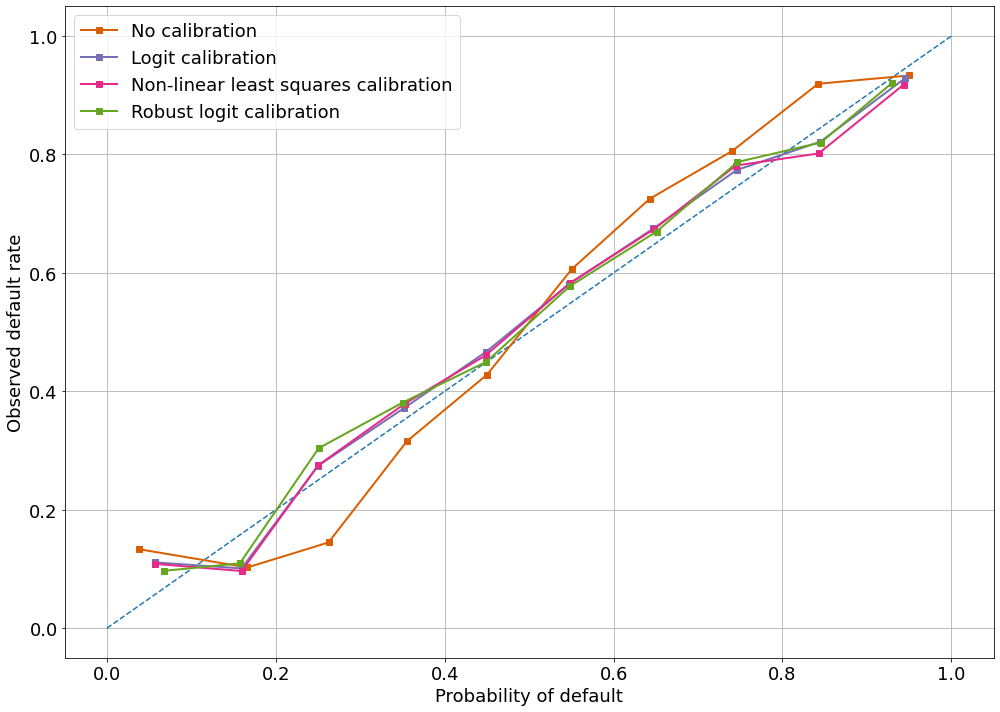

In [179]:
# Sources:
# https://machinelearningmastery.com/calibrated-classification-model-in-scikit-learn/
# https://scikit-learn.org/stable/auto_examples/calibration/plot_calibration_curve.html

fig = plt.figure(figsize=(14, 10))
gs = GridSpec(4, 2)
colors = plt.cm.get_cmap("Dark2")

# plot perfect calibration
plt.plot([0, 1], [0, 1], linestyle='--')

# get calibration curves
fop, mpv = calibration_curve(pf_val.Observed, pf_val.Predicted, n_bins=10, strategy='uniform')
fop2, mpv2 = calibration_curve(pf_val.Observed, pf_val.logit_pd, n_bins=10, strategy='uniform')
fop3, mpv3 = calibration_curve(pf_val.Observed, pf_val.nonlin_ls_pd, n_bins=10, strategy='uniform')
fop4, mpv4 = calibration_curve(pf_val.Observed, pf_val.rob_logit_pd, n_bins=10, strategy='uniform')

# plot model calibration
plt.plot(mpv, fop, marker="s", linewidth=2, label='No calibration', color = colors(1))
plt.plot(mpv2, fop2, marker="s", linewidth=2,label='Logit calibration', color = colors(2))
plt.plot(mpv3, fop3, marker="s", linewidth=2,label='Non-linear least squares calibration', color = colors(3))
plt.plot(mpv4, fop4, marker="s", linewidth=2,label='Robust logit calibration', color = colors(4))

plt.grid()
plt.tick_params(labelsize=18)

plt.xlabel('Probability of default', fontsize=18)
plt.ylabel('Observed default rate', fontsize=18)

plt.legend(fontsize=18)
plt.tight_layout()
# plt.savefig('calibration_diagram.png', bbox_inches='tight')
plt.show()

In [180]:
print('----------------------------------------------')
print('--------    Brier scores (overall)    --------')
print('----------------------------------------------')

print(f"No calibration : {brier_score_loss(pf_val.Observed, pf_val.Predicted):.2%}")
print(f"Logit calibration : {brier_score_loss(pf_val.Observed, pf_val.logit_pd):.2%}")
print(f"Non-linear least squares calibration : {brier_score_loss(pf_val.Observed, pf_val.nonlin_ls_pd):.2%}")
print(f"Robust logit calibration : {brier_score_loss(pf_val.Observed, pf_val.rob_logit_pd):.2%}")

print('----------------------------------------------')
print('--------  Expected Calibration Error  --------')
print('----------------------------------------------')

print(f"No calibration : {get_metrics(pf.Observed, pf.Predicted)[0]:.2%}")
print(f"Logit calibration : {get_metrics(pf_val.Observed, pf_val.logit_pd)[0]:.2%}")
print(f"Non-linear least squares calibration : {get_metrics(pf_val.Observed, pf_val.nonlin_ls_pd)[0]:.2%}")
print(f"Robust logit calibration : {get_metrics(pf_val.Observed, pf_val.rob_logit_pd)[0]:.2%}")

print('----------------------------------------------')
print('--------  Maximum Calibration Error   --------')
print('----------------------------------------------')

print(f"No calibration : {get_metrics(pf.Observed, pf.Predicted)[1]:.2%}")
print(f"Logit calibration : {get_metrics(pf_val.Observed, pf_val.logit_pd)[1]:.2%}")
print(f"Non-linear least squares calibration : {get_metrics(pf_val.Observed, pf_val.nonlin_ls_pd)[1]:.2%}")
print(f"Robust logit calibration : {get_metrics(pf_val.Observed, pf_val.rob_logit_pd)[1]:.2%}")

----------------------------------------------
--------    Brier scores (overall)    --------
----------------------------------------------
No calibration : 20.87%
Logit calibration : 20.57%
Non-linear least squares calibration : 20.56%
Robust logit calibration : 20.56%
----------------------------------------------
--------  Expected Calibration Error  --------
----------------------------------------------
No calibration : 4.80%
Logit calibration : 2.70%
Non-linear least squares calibration : 2.95%
Robust logit calibration : 2.80%
----------------------------------------------
--------  Maximum Calibration Error   --------
----------------------------------------------
No calibration : 9.30%
Logit calibration : 5.85%
Non-linear least squares calibration : 6.31%
Robust logit calibration : 5.32%
